<a href="https://colab.research.google.com/github/AnnPhann2204/EEG-AD_DeepLearning/blob/main/RNN_EEG_AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MAlessandrini-Univpm/rnn-eeg-ad.git

fatal: destination path 'rnn-eeg-ad' already exists and is not an empty directory.


In [2]:
%cd rnn-eeg-ad

/content/rnn-eeg-ad


In [3]:
!ls

20241015-144311.txt  20241015-203216.txt	       eeg2		    README.md
20241015-150812.txt  batch_cross_val.py		       LICENSE		    requirements.txt
20241015-153912.txt  batch_spikes.py		       logs		    rnn-eeg-ad
20241015-160735.txt  batch_test.py		       model.pdf	    rnn_eeg_ad.py
20241015-164305.txt  confusion_matrix.eps	       mspca.m		    r_pca.py
20241015-172120.txt  confusion_matrix_ICA.png	       mu_golden_search.py
20241015-192827.txt  confusion_matrix_withoutRPCA.eps  parse_log.py
20241015-195036.txt  confusion_matrix_withoutRPCA.png  __pycache__


In [4]:
!pip install mne

In [5]:
import mne

In [6]:
import numpy as np

# Load the .npz file from the 'eeg2' folder
data = np.load('eeg2/S01_N.npz')

# List all arrays stored in the .npz file
print(data.files)

# Access the 'eeg' array (or other arrays listed)
eeg_array = data['eeg']
print(eeg_array)


['eeg']
[[ 24.88347878  24.88347878  24.88347878 ...  25.63371875  10.00371951
   -2.25019989]
 [ 24.88347878  24.88347878  24.88347878 ...  21.38235895  26.38395871
   19.38171905]
 [ 24.88347878  24.88347878  24.88347878 ...  19.13163906   0.25059998
  -21.38131896]
 ...
 [ 24.88347878  24.88347878  24.88347878 ...   3.00147985   2.75139986
   -9.12739956]
 [ 24.88347878  24.88347878  24.88347878 ...  31.63563845   6.0024397
  -18.25531911]
 [ 24.88347878  24.88347878  24.88347878 ...  15.13035926   7.75299962
   -2.50027988]]


In [7]:
eeg_array.shape

(16, 111232)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Softmax, Dropout, Bidirectional
import scipy.io  # to load/save MAT files
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.decomposition
import sklearn.model_selection
import sys
import os
# %matplotlib inline
# %load_ext tensorboard

tf.random.set_seed(42)
np.random.seed(42)

print('Tf Keras:', keras.__version__)
print('TensorFlow:', tf.__version__)
print('GPU device:', tf.test.gpu_device_name())

if 'google.colab' in sys.modules:  # try to detect if we're running in colab or locally
  # working_dir = '/content/drive/MyDrive/Colab Notebooks'
  working_dir = '/content/rnn-eeg-ad'
#   %cp '/content/drive/MyDrive/Colab Notebooks/r_pca.py' .
else:
  working_dir = '.'

import r_pca
multiscale_pca = False  # Compute MSPCA before PCA
log_dir_base = working_dir + '/logs/fit'
num_classes = 2

Tf Keras: 3.4.1
TensorFlow: 2.17.0
GPU device: 


In [9]:

def create_dataset(window, overlap, decimation_factor = 0):
  # Create the input and target data from dataset,
  # according to window and overlap
  # new dataset 4 dec 2021
  # 15 N, 20 AD (resulting indexes: N = 0..14, AD = 15..34)
  # 16 Common signals: ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']

  tf.random.set_seed(42)
  np.random.seed(42)
  dataset_dir = working_dir + '/eeg2'
  subj_list = tuple((f'{i:02d}', 'N') for i in range(1, 16)) + tuple((f'{i:02d}', 'AD') for i in range(1, 21))
  print(subj_list)
  num_columns = 16

  x_data = np.empty((0, window, num_columns))
  y_data = np.empty((0, 1))  # labels
  subj_inputs = []  # number of inputs for every subject
  print('\n### creating dataset')
  tot_rows = 0
  for subject in subj_list:
    subj_inputs.append(0)
    category = ('N', 'AD').index(subject[1])
    eeg = np.load(f'{dataset_dir}/S{subject[0]}_{subject[1]}.npz')['eeg'].T
    print(f"Subject: {subject}, EEG shape: {eeg.shape}")
    if spikes: eeg = set_holes(eeg, spikes)
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    eeg = scaler.fit_transform(eeg)
    assert(eeg.shape[1] == num_columns)
    tot_rows += len(eeg)
    # decimation (optional)
    if decimation_factor:
      eeg2 = np.empty((eeg.shape[0] // decimation_factor, eeg.shape[1])) #downsampling
      for col in range(0, num_columns):
        #tmp = scipy.signal.decimate(fusion[:, col], decimation_factor)
        tmp = eeg[:, col][::decimation_factor]  # simpler method
        eeg2[:, col] = tmp[:len(eeg2)]
      eeg = eeg2
    # windowing
    # compute number of windows (lazy way)
    i = 0
    num_w = 0
    while i + window  <= len(eeg):
      i += (window - overlap)
      num_w += 1
    # compute actual windows
    x_data_part = np.empty((num_w, window, num_columns))  # preallocate
    i = 0
    for w in range(0, num_w):
      x_data_part[w] = eeg[i:i + window]
      i += (window - overlap)
      if False: # watermark provenience of every window
        for cc in range(0, num_columns):
          x_data_part[w, 0, cc] = 1000 * (len(subj_inputs) - 1) + cc
    x_data = np.vstack((x_data, x_data_part))
    y_data = np.vstack((y_data, np.full((num_w, 1), category)))
    subj_inputs[-1] += num_w

  print('\ntot samples:', tot_rows)
  print('x_data:', x_data.shape)
  print('y_data:', y_data.shape)
  print('windows per subject:', subj_inputs)
  print('class distribution:', [np.sum(y_data == cl) for cl in range(0, num_classes)])

  return x_data, y_data, subj_inputs

In [10]:
def set_holes(A, prob):
  for i in range(0, len(A)):
    if np.random.rand() < prob:
      l = 20
      l = int(np.random.normal(l, l / 2))
      A[i:i+l,:] = 0
  return A


def partition_data(subjects):
  # subjects = tuple (0-based)
  x_part = None
  y_part = None
  subj_inputs_part = []
  for subj in subjects:
    subj_inputs_part.append(subj_inputs[subj])
    skip = sum(subj_inputs[:subj])
    num = subj_inputs[subj]
    xx = x_data[skip : skip + num]
    yy = y_data[skip : skip + num]
    if x_part is None:
      x_part = xx.copy()
      y_part = yy.copy()
    else:
      x_part = np.vstack((x_part, xx))  # vstack creates a copy of the data
      y_part = np.vstack((y_part, yy))
  print('---------partition_data-----------')
  # print('x_part:', x_part.shape)
  # print('y_part:', y_part.shape)
  # print('subj_inputs_part:', len(subj_inputs_part))
  return x_part, y_part, subj_inputs_part


def oversampling(x_data, y_data):
  # Duplicate inputs with classes occurring less, so to have a more balanced distribution.
  # It operates on single data windows, so use it on data that have already been split
  #  by subject (typically only on training data).

  print('---------oversampling-----------')
  x_data_over = x_data.copy()
  y_data_over = y_data.copy()
  occurr = [np.sum(y_data == cl) for cl in range(0, num_classes)]
  for cl in range(0, num_classes):
    if occurr[cl] == max(occurr):
      continue
    mask = y_data[:, 0] == cl
    x_dup = x_data[mask].copy()
    y_dup = y_data[mask].copy()
    while occurr[cl] < max(occurr):
      x_dup_jitter = x_dup + np.random.normal(scale=0.03, size=x_dup.shape)
      how_many = min(len(y_dup), max(occurr) - occurr[cl])
      x_data_over = np.vstack((x_data_over, x_dup_jitter[:how_many]))
      y_data_over = np.vstack((y_data_over, y_dup[:how_many]))
      occurr[cl] += how_many
  return x_data_over, y_data_over


def create_model(sample_window, dense1, lstm1, lstm2, lstm3 = 0, dropout = 0.2):
  print("\n### creating model")
  model = keras.Sequential()
  model.add(keras.Input(shape = sample_window.shape, name = 'input'))
  if dense1: model.add(Dense(dense1, name = 'dense1'))
  #model.add(BatchNormalization(name = 'norm1'))
  #model.add(Dropout(dropout, name = 'drop1'))
  model.add(LSTM(lstm1, return_sequences = bool(lstm2), name = 'lstm1'))
  if lstm2:
    model.add(Dropout(dropout, name = 'drop2'))
    model.add(LSTM(lstm2, return_sequences = bool(lstm3), name = 'lstm2'))
  if lstm3:
    model.add(Dropout(dropout, name = 'drop4'))
    model.add(LSTM(lstm3, name = 'lstm3'))
  model.add(Dropout(dropout, name = 'drop3'))
  model.add(Dense(num_classes, name = 'dense2'))
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  return model

from sklearn.decomposition import FastICA
import numpy as np
import scipy.io
import os
# from robust_pca import R_pca  # Assuming you saved the RPCA class as robust_pca.py


In [11]:
import mne
from mne.preprocessing import ICA
from mne import create_info
from mne.io import RawArray
def pca_ica_rpca_reduction(A, tol=1e-6, comp=0, method='pca', rpca_mu=None):
    """
    Parameters:
    - A: Input matrix (2D array)
    - tol: Tolerance for RPCA or PCA truncation (for ICA it's passed to FastICA)
    - comp: Number of components (optional, default is 0 for automatic selection)
    - method: 'pca', 'ica', or 'rpca' to specify the reduction technique
    - rpca_mu: Optional parameter for RPCA if a custom mu is needed

    Returns:
    - L: The transformed matrix after applying PCA/ICA/RPCA
    - V: The matrix of selected components (for PCA/ICA) or the sparse matrix (for RPCA)
    """
    assert len(A.shape) == 2  # Ensure A is a 2D matrix
    dmin = min(A.shape)  # Get the smaller dimension of the matrix

    if method == 'pca':
        print('Performing PCA...')
        U, lam, V = np.linalg.svd(A, full_matrices=False)  # Singular value decomposition
        assert U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1])
        lam_trunc = lam[lam > 0.015 * lam[0]]
        p = comp if comp else len(lam_trunc)
        assert p <= dmin
        print('PCA truncation', dmin, '->', p)
        return A, V.T[:, :p]

    elif method == 'ica':
        # # First apply PCA as a preprocessing step
        # print('Performing PCA as preprocessing...')
        # U, lam, Vpca = np.linalg.svd(A, full_matrices=False)
        # lam_trunc = lam[lam > 0.015 * lam[0]]
        # p_pca = comp if comp else len(lam_trunc)
        # A_pca = A @ Vpca.T[:, :p_pca]  # Reduced dimensionality matrix after PCA
        # print(f'PCA completed: reduced to {p_pca} components.')

        # # Create info object (required by MNE ICA)
        # n_channels, n_times = A_pca.shape
        # info = create_info(ch_names=[f'ch{i}' for i in range(n_channels)], sfreq=128, ch_types='eeg')

        # # Convert PCA-reduced data to RawArray (required by MNE ICA)
        # raw = RawArray(A_pca, info)

        # # Apply MNE ICA
        # print('Performing ICA using MNE...')
        # ica = ICA(n_components=p_pca, max_iter="auto", random_state=97)
        # ica.fit(raw)  # Fit ICA to the raw data

        # # Apply ICA to raw data (returns transformed data)
        # ica.apply(raw)  # Apply the ICA solution to the data

        # # Retrieve the ICA mixing matrix and the transformed signals
        # L = raw.get_data()  # Transformed data after applying ICA
        # Vica = ica.get_components()  # ICA mixing matrix (components from ICA)
        # print('ICA components:', Vica.shape)
        # print(L.shape)
        # return L, Vica

        print('Performing ICA...')
        ica = sklearn.decomposition.FastICA(n_components=comp, max_iter=1500, random_state=42, tol=1e-1)
        L = ica.fit_transform(A)  # L is the reduced matrix
        V = ica.mixing_  # V is the mixing matrix (components)
        print('ICA components:', V.shape)
        return L, V

    elif method == 'rpca':
        print('Performing RPCA...')
        r = r_pca.R_pca(A, mu=rpca_mu)
        print('Auto tol:', 1e-7 * r.frobenius_norm(r.D), 'used tol:', tol)
        print('mu:', r.mu, 'lambda:', r.lmbda)
        L, S = r.fit(tol=tol, max_iter=10, iter_print=1)
        global norm_s
        norm_s = np.linalg.norm(S, ord='fro')
        print('||A,L,S||:', np.linalg.norm(A, ord='fro'), np.linalg.norm(L, ord='fro'), np.linalg.norm(S, ord='fro'))
        U, lam, V = np.linalg.svd(L, full_matrices = False)  # V is transposed
        assert(U.shape == (A.shape[0], dmin) and lam.shape == (dmin,) and V.shape == (dmin, A.shape[1]))
        #np.savetxt('singular_values.csv', lam)
        lam_trunc = lam[lam > 0.015 * lam[0]]  # magic number
        p = comp if comp else len(lam_trunc)
        assert(p <= dmin)
        print('PCA truncation', dmin, '->', p)
        return L, V.T[:,:p]

    else:
        raise ValueError("Invalid method. Choose from 'pca', 'ica', or 'rpca'.")

def reduce_matrix(A, V, method):

    print('---------reduce_matrix-----------')
    # (N, w, 16) → (N, 16, w) → ((N*16), w) → compute V
    # (N, 16, w) * V → transpose again last dimensions
    B = np.swapaxes(A, 1, 2)  # (N, 16, w)
    C = B.reshape((-1, B.shape[2]))  # ((N*16), w)
    if V is None:
        L, V = pca_ica_rpca_reduction(C, tol=5e-6, comp=min(50, C.shape[1]), method=method)
    # if V is None:
    #     L, V = pca_ica_rpca_reduction(C, tol=5e-6, comp=50, method=method)
    if C.shape[1] != V.shape[0]:
        raise ValueError(f"Matrix dimension mismatch: C has {C.shape[1]} columns, but V has {V.shape[0]} rows.")
    B = C @ V  # ((N*16), p)
    B = B.reshape((A.shape[0], A.shape[2], B.shape[1]))  # (N, 16, p)
    return np.swapaxes(B, 1, 2), V  # B = (N, p, 16)


def adjust_size(x, y):
  # when flattening the data matrix on the first dimension, y must be made compatible
  if len(x) == len(y): return y
  factor = len(x) // len(y)
  ynew = np.empty((len(x), 1))
  for i in range(0, len(y)):
    ynew[i * factor : (i + 1) * factor] = y[i]
  return ynew


In [12]:
def train_session(save_model = False, load_model = None, write_report = True, file_id = '', earlystop = 0, train_split = 0.75, method = 'ica'):
  def write_values():
    print(time.strftime('%H:%M:%S'), file = out_f)
    print('window', window, 'overlap', overlap, 'decimation', decimation, file = out_f)
    print('layers', dense1, lstm1, lstm2, lstm3, file = out_f)
    print('oversample', oversample, file = out_f)
    print('pca', pca, file = out_f)
    print('rpca', rpca, file = out_f)
    print('mspca', multiscale_pca, file = out_f)
    print('subj_train', permutation, file = out_f)
    print('epochs', epochs, file = out_f)
    if history is not None:
      print('fit_accuracy', [round(x, 4) for x in history.history['accuracy']], file = out_f)
    if history is not None and 'val_accuracy' in history.history:
      print('fit_val_accuracy', [round(x, 4) for x in history.history['val_accuracy']], file = out_f)
    print('subj_test', subjs_test[perm_index] if subjs_test and type(subjs_test[0]) == tuple else subjs_test, file = out_f)
    if subjs_test: print('test_accuracy', round(eval_metrics[1], 4), file = out_f)
    print('permutation', perm_index + 1, file = out_f)
    print('train_size', len(x_data_train), file = out_f)
    print('p', 0 if Vpca is None else Vpca.shape[1], file = out_f)
    print('spikes', spikes, file = out_f)
    print('time_train', time_train, file = out_f)
    if subjs_test: print('time_test', time_test, file = out_f)
    print(file = out_f)
    out_f.flush()

  if write_report:
    output_file = time.strftime('%Y%m%d-%H%M%S') + file_id + '.txt'
    out_f = open(working_dir + '/' + output_file, 'w')
  log_dir = log_dir_base + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  for perm_index, permutation in enumerate(subjs_train_perm):
    assert(type(permutation) == tuple)
    assert(len(permutation) == 2)
    assert(type(permutation[0]) == tuple)
    assert(type(permutation[1]) == tuple)
    assert(type(subjs_test) == tuple)
    tf.random.set_seed(42)
    np.random.seed(42)
    x_data_train, y_data_train, _ = partition_data(permutation[0])  # train subjects
    x_data_val, y_data_val, _ = partition_data(permutation[1])  # validation subjects, can be None
    if oversample:
      print('\nclass distribution (training subset):', [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
      x_data_train, y_data_train = oversampling(x_data_train, y_data_train)
      print('After oversampling (training subset):')
      print('x_data_train:', x_data_train.shape)
      print('y_data_train:', y_data_train.shape)
      print('class distribution:', [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
    if False:
      #for i in range(0, len(x_data_train)):
      #  x_data_train[i] = set_holes(x_data_train[i], spikes)
      for w in range(0, len(x_data_train)):  # every window
        for c in range(0, x_data_train.shape[2]):  # every column
          if np.random.rand() < spikes:
            t = 1
            for r in range(0, x_data_train.shape[1] // 2):
              x_data_train[w, r + x_data_train.shape[1] // 4 , c] = t
              t *= -1
    # if train_split != 0, we ignore the provided x_data_val and split training in training + validation (Laura)
    if train_split:
      x_data_train, x_data_val, y_data_train, y_data_val = sklearn.model_selection.train_test_split(x_data_train, y_data_train, train_size = train_split, random_state=42, shuffle=True)
    #np.savez_compressed('x_data_train.npz', x_data_train = x_data_train)
    #print('x_data_train saved')

    x_data_train, Vpca = reduce_matrix(x_data_train, None, method=method)
    y_data_train = adjust_size(x_data_train, y_data_train)
    if x_data_val is not None:
      x_data_val, _ = reduce_matrix(x_data_val, Vpca, method=method)
      y_data_val = adjust_size(x_data_val, y_data_val)
    print('x_data_train:', x_data_train.shape)
    print('y_data_train:', y_data_train.shape, [np.sum(y_data_train == cl) for cl in range(0, num_classes)])
    if x_data_val is not None:
      print('x_data_val:', x_data_val.shape)
      print('y_data_val:', y_data_val.shape, [np.sum(y_data_val == cl) for cl in range(0, num_classes)])

    if load_model is None:
      model = create_model(x_data_train[0], dense1, lstm1, lstm2, lstm3)
      # draw model to PNG
      keras.utils.plot_model(model, to_file = working_dir + '/model.pdf', show_shapes = True)
      # model training
      print(f'\n### training with {permutation[0]}, {len(x_data_train)} inputs, {len(x_data_val) if x_data_val is not None else 0} validation')
      callbacks = [keras.callbacks.TensorBoard(log_dir + f'_{perm_index + 1}', histogram_freq = 1)]
      if earlystop:
        callbacks.append(keras.callbacks.EarlyStopping('val_accuracy', min_delta = 0.001, patience = earlystop, restore_best_weights = True, verbose = 1))
      # train
      start_time = time.monotonic()
      history = model.fit(x_data_train, y_data_train, epochs = epochs,
        validation_data = (x_data_val, y_data_val) if x_data_val is not None else None,
        callbacks = callbacks)
      time_train = time.monotonic() - start_time
    else:
      # model must match with dataset parameters
      model = keras.models.load_model(load_model)
      history = None
      time_train = 0

    # model test
    if subjs_test:
      x_data_test, y_data_test, _ = partition_data(subjs_test[perm_index] if type(subjs_test[0]) == tuple else subjs_test)
      if pca:
        x_data_test, _ = reduce_matrix(x_data_test, Vpca, method)
        y_data_test = adjust_size(x_data_test, y_data_test)
      print(f'\n### testing with {subjs_test[perm_index] if type(subjs_test[0]) == tuple else subjs_test}, {len(x_data_test)} inputs')
      start_time = time.monotonic()
      eval_metrics = model.evaluate(x_data_test, y_data_test)
      time_test = time.monotonic() - start_time
    else:
      eval_metrics = [0., 0.]
    if write_report:
      write_values()
    if save_model:
      # save in both directory and h5 formats (we had problems with both of them sometimes)
      model_file_name = f'{working_dir}/{file_id}model_w{window:04d}_o{overlap:03d}_d{decimation:03d}_e{epochs}_t{round(eval_metrics[1] * 10000)}'
      #model.save(model_file_name)
      model.save(model_file_name + '.h5')
  if write_report:
    out_f.close()

  return model, x_data_test, y_data_test, eval_metrics[1]  # can be needed by other blocks


# With RPCA

In [13]:

"""---
**Start of actual program blocks:**
"""

# create dataset, create model, train and test
# if __name__ == '__main__':
dense1 = 0
lstm1 = 8
lstm2 = 8
lstm3 = 0
method = 'rpca'
window = 512
overlap = window // 2
oversample = True
decimation = 0
pca = True  # compute PCA on full data matrix
rpca = False  # compute RPCA before PCA
spikes = 1/500
rpca_mu = 0.1

subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 32)), ()), )
# subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 35)), ()), )
subjs_test = (0, 1, 15, 16, 17)  # 2 for N, 3 for AD
epochs = 20

  # if decimation:
  #   window //= decimation
  #   overlap //= decimation

x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation)



(('01', 'N'), ('02', 'N'), ('03', 'N'), ('04', 'N'), ('05', 'N'), ('06', 'N'), ('07', 'N'), ('08', 'N'), ('09', 'N'), ('10', 'N'), ('11', 'N'), ('12', 'N'), ('13', 'N'), ('14', 'N'), ('15', 'N'), ('01', 'AD'), ('02', 'AD'), ('03', 'AD'), ('04', 'AD'), ('05', 'AD'), ('06', 'AD'), ('07', 'AD'), ('08', 'AD'), ('09', 'AD'), ('10', 'AD'), ('11', 'AD'), ('12', 'AD'), ('13', 'AD'), ('14', 'AD'), ('15', 'AD'), ('16', 'AD'), ('17', 'AD'), ('18', 'AD'), ('19', 'AD'), ('20', 'AD'))

### creating dataset
Subject: ('01', 'N'), EEG shape: (111232, 16)
Subject: ('02', 'N'), EEG shape: (97280, 16)
Subject: ('03', 'N'), EEG shape: (94720, 16)
Subject: ('04', 'N'), EEG shape: (199808, 16)
Subject: ('05', 'N'), EEG shape: (145920, 16)
Subject: ('06', 'N'), EEG shape: (116608, 16)
Subject: ('07', 'N'), EEG shape: (160896, 16)
Subject: ('08', 'N'), EEG shape: (240640, 16)
Subject: ('09', 'N'), EEG shape: (200064, 16)
Subject: ('10', 'N'), EEG shape: (145536, 16)
Subject: ('11', 'N'), EEG shape: (144768, 16

In [14]:

model, x_data_test, y_data_test, test_acc = train_session(save_model = False, earlystop = 0,method = 'rpca')  # returned variables can be optionally used by other blocks of code

---------partition_data-----------
---------partition_data-----------

class distribution (training subset): [8135, 10043]
---------oversampling-----------
After oversampling (training subset):
x_data_train: (20086, 512, 16)
y_data_train: (20086, 1)
class distribution: [10043, 10043]
---------reduce_matrix-----------
Performing RPCA...
Auto tol: 0.0011176655627888079 used tol: 5e-06
mu: 189.37998264492805 lambda: 0.0020369006894007243
iteration: 1, error: 0.07015150436516683, ||S||: 0.0721284818922337
iteration: 2, error: 3.62080536176879e-06, ||S||: 0.14425488584764504
||A,L,S||: 11176.655627888078 11176.621929298784 0.14425488584764504
PCA truncation 512 -> 50
---------reduce_matrix-----------
x_data_train: (15064, 50, 16)
y_data_train: (15064, 1) [7573, 7491]
x_data_val: (5022, 50, 16)
y_data_val: (5022, 1) [2470, 2552]

### creating model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 50, 8)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 50, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (LSTM)                         │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop3 (Dropout)                      │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


### training with (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31), 15064 inputs, 5022 validation
Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.5783 - loss: 0.6576 - val_accuracy: 0.8068 - val_loss: 0.4362
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8255 - loss: 0.4137 - val_accuracy: 0.8590 - val_loss: 0.3418
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8678 - loss: 0.3393 - val_accuracy: 0.8777 - val_loss: 0.2999
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8887 - loss: 0.2857 - val_accuracy: 0.9038 - val_loss: 0.2464
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.9056 - loss: 0.2481 - val_accuracy: 0.9184 - val_loss: 0.2179
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9172 - loss: 0.2207 - val_accuracy: 0.9297 - val_loss: 0.1949
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9

In [15]:
# model test only
# if False and __name__ == '__main__':
print(f'### testing with {len(x_data_test)} inputs')
eval_metrics = model.evaluate(x_data_test, y_data_test)


### testing with 2936 inputs
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8512 - loss: 0.3503


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


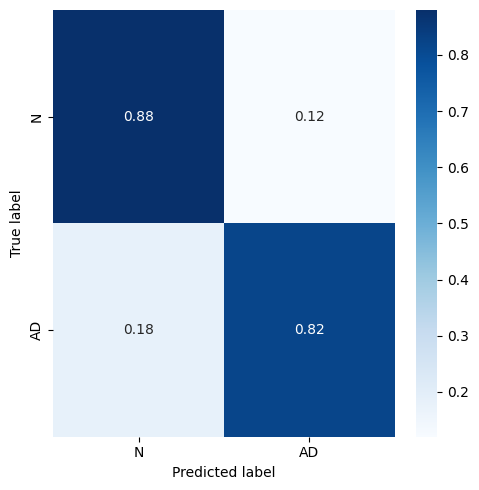

In [16]:
# # create confusion matrix
# if False and __name__ == '__main__':
import pandas as pd
import seaborn
y_pred = np.argmax(model.predict(x_data_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
classes = ['N', 'AD']
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize = (5, 5))
seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(working_dir + '/confusion_matrix_withoutRPCA.png', dpi = 600)
plt.show()

# With PCA Only

In [17]:

"""---
**Start of actual program blocks:**
"""

# create dataset, create model, train and test
# if __name__ == '__main__':
dense1 = 0
lstm1 = 8
lstm2 = 8
lstm3 = 0
method = 'pca'
window = 512
overlap = window // 2
oversample = True
decimation = 0
pca = True  # compute PCA on full data matrix
rpca = False  # compute RPCA before PCA
spikes = 1/500
rpca_mu = 0.1

subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 32)), ()), )
# subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 35)), ()), )
subjs_test = (0, 1, 15, 16, 17)  # 2 for N, 3 for AD
epochs = 20

  # if decimation:
  #   window //= decimation
  #   overlap //= decimation

x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation)



(('01', 'N'), ('02', 'N'), ('03', 'N'), ('04', 'N'), ('05', 'N'), ('06', 'N'), ('07', 'N'), ('08', 'N'), ('09', 'N'), ('10', 'N'), ('11', 'N'), ('12', 'N'), ('13', 'N'), ('14', 'N'), ('15', 'N'), ('01', 'AD'), ('02', 'AD'), ('03', 'AD'), ('04', 'AD'), ('05', 'AD'), ('06', 'AD'), ('07', 'AD'), ('08', 'AD'), ('09', 'AD'), ('10', 'AD'), ('11', 'AD'), ('12', 'AD'), ('13', 'AD'), ('14', 'AD'), ('15', 'AD'), ('16', 'AD'), ('17', 'AD'), ('18', 'AD'), ('19', 'AD'), ('20', 'AD'))

### creating dataset
Subject: ('01', 'N'), EEG shape: (111232, 16)
Subject: ('02', 'N'), EEG shape: (97280, 16)
Subject: ('03', 'N'), EEG shape: (94720, 16)
Subject: ('04', 'N'), EEG shape: (199808, 16)
Subject: ('05', 'N'), EEG shape: (145920, 16)
Subject: ('06', 'N'), EEG shape: (116608, 16)
Subject: ('07', 'N'), EEG shape: (160896, 16)
Subject: ('08', 'N'), EEG shape: (240640, 16)
Subject: ('09', 'N'), EEG shape: (200064, 16)
Subject: ('10', 'N'), EEG shape: (145536, 16)
Subject: ('11', 'N'), EEG shape: (144768, 16

In [18]:

model, x_data_test, y_data_test, test_acc = train_session(save_model = False, earlystop = 0,method = 'pca')  # returned variables can be optionally used by other blocks of code

---------partition_data-----------
---------partition_data-----------

class distribution (training subset): [8135, 10043]
---------oversampling-----------
After oversampling (training subset):
x_data_train: (20086, 512, 16)
y_data_train: (20086, 1)
class distribution: [10043, 10043]
---------reduce_matrix-----------
Performing PCA...
PCA truncation 512 -> 50
---------reduce_matrix-----------
x_data_train: (15064, 50, 16)
y_data_train: (15064, 1) [7573, 7491]
x_data_val: (5022, 50, 16)
y_data_val: (5022, 1) [2470, 2552]

### creating model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 50, 8)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 50, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (LSTM)                         │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop3 (Dropout)                      │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


### training with (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31), 15064 inputs, 5022 validation
Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5510 - loss: 0.6637 - val_accuracy: 0.7459 - val_loss: 0.4970
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.7984 - loss: 0.4458 - val_accuracy: 0.8560 - val_loss: 0.3405
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8702 - loss: 0.3252 - val_accuracy: 0.8909 - val_loss: 0.2761
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.8952 - loss: 0.2727 - val_accuracy: 0.9056 - val_loss: 0.2406
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9129 - loss: 0.2348 - val_accuracy: 0.9176 - val_loss: 0.2134
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9264 - loss: 0.2050 - val_accuracy: 0.9289 - val_loss: 0.1944
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9

In [19]:
# model test only
# if False and __name__ == '__main__':
print(f'### testing with {len(x_data_test)} inputs')
eval_metrics = model.evaluate(x_data_test, y_data_test)


### testing with 2936 inputs
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8767 - loss: 0.3350


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


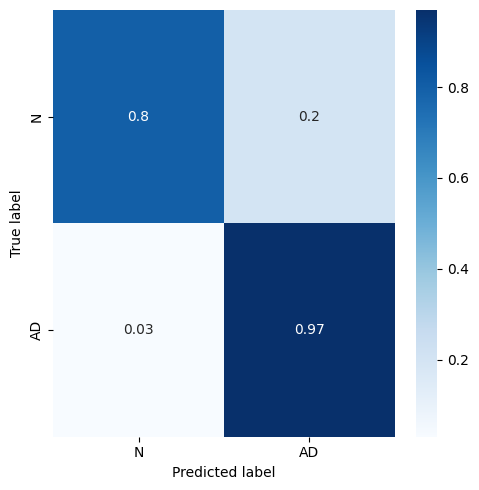

In [20]:
# # create confusion matrix
# if False and __name__ == '__main__':
import pandas as pd
import seaborn
y_pred = np.argmax(model.predict(x_data_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
classes = ['N', 'AD']
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize = (5, 5))
seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(working_dir + '/confusion_matrix_withoutRPCA.png', dpi = 600)
plt.show()

# With ICA

In [21]:

"""---
**Start of actual program blocks:**
"""

# create dataset, create model, train and test
# if __name__ == '__main__':
dense1 = 0
lstm1 = 8
lstm2 = 8
lstm3 = 0
method = 'ica'
window = 512
overlap = window // 2
oversample = True
decimation = 0
pca = True  # compute PCA on full data matrix
rpca = True  # compute RPCA before PCA
spikes = 1/500
rpca_mu = 0.1
train_split = 0.75
subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 32)), ()), )
# subjs_train_perm = ( (tuple(i for i in range(2, 15)) + tuple(i for i in range(18, 35)), ()), )
subjs_test = (0, 1, 15, 16, 17)  # 2 for N, 3 for AD

x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation)



(('01', 'N'), ('02', 'N'), ('03', 'N'), ('04', 'N'), ('05', 'N'), ('06', 'N'), ('07', 'N'), ('08', 'N'), ('09', 'N'), ('10', 'N'), ('11', 'N'), ('12', 'N'), ('13', 'N'), ('14', 'N'), ('15', 'N'), ('01', 'AD'), ('02', 'AD'), ('03', 'AD'), ('04', 'AD'), ('05', 'AD'), ('06', 'AD'), ('07', 'AD'), ('08', 'AD'), ('09', 'AD'), ('10', 'AD'), ('11', 'AD'), ('12', 'AD'), ('13', 'AD'), ('14', 'AD'), ('15', 'AD'), ('16', 'AD'), ('17', 'AD'), ('18', 'AD'), ('19', 'AD'), ('20', 'AD'))

### creating dataset
Subject: ('01', 'N'), EEG shape: (111232, 16)
Subject: ('02', 'N'), EEG shape: (97280, 16)
Subject: ('03', 'N'), EEG shape: (94720, 16)
Subject: ('04', 'N'), EEG shape: (199808, 16)
Subject: ('05', 'N'), EEG shape: (145920, 16)
Subject: ('06', 'N'), EEG shape: (116608, 16)
Subject: ('07', 'N'), EEG shape: (160896, 16)
Subject: ('08', 'N'), EEG shape: (240640, 16)
Subject: ('09', 'N'), EEG shape: (200064, 16)
Subject: ('10', 'N'), EEG shape: (145536, 16)
Subject: ('11', 'N'), EEG shape: (144768, 16

In [22]:
epochs = 20
model, x_data_test, y_data_test, test_acc = train_session(save_model = False, earlystop = 0, method = 'ica')  # returned variables can be optionally used by other blocks of code

---------partition_data-----------
---------partition_data-----------

class distribution (training subset): [8135, 10043]
---------oversampling-----------
After oversampling (training subset):
x_data_train: (20086, 512, 16)
y_data_train: (20086, 1)
class distribution: [10043, 10043]
---------reduce_matrix-----------
Performing ICA...


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


ICA components: (512, 50)
---------reduce_matrix-----------
x_data_train: (15064, 50, 16)
y_data_train: (15064, 1) [7573, 7491]
x_data_val: (5022, 50, 16)
y_data_val: (5022, 1) [2470, 2552]

### creating model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 50, 8)               │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 50, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (LSTM)                         │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop3 (Dropout)                      │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,362 (5.32 KB)

 Trainable params: 1,362 (5.32 KB)

 Non-trainable params: 0 (0.00 B)


### training with (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31), 15064 inputs, 5022 validation
Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6533 - loss: 0.6058 - val_accuracy: 0.8596 - val_loss: 0.3422
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8722 - loss: 0.3189 - val_accuracy: 0.8903 - val_loss: 0.2677
Epoch 3/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9028 - loss: 0.2529 - val_accuracy: 0.9092 - val_loss: 0.2296
Epoch 4/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9142 - loss: 0.2176 - val_accuracy: 0.9186 - val_loss: 0.2050
Epoch 5/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9268 - loss: 0.1882 - val_accuracy: 0.9249 - val_loss: 0.1934
Epoch 6/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9319 - loss: 0.1745 - val_accuracy: 0.9275 - val_loss: 0.1794
Epoch 7/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9

In [23]:
# model test only
# if False and __name__ == '__main__':
print(f'### testing with {len(x_data_test)} inputs')
eval_metrics = model.evaluate(x_data_test, y_data_test)


### testing with 2936 inputs
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3635 - loss: 2.8338


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


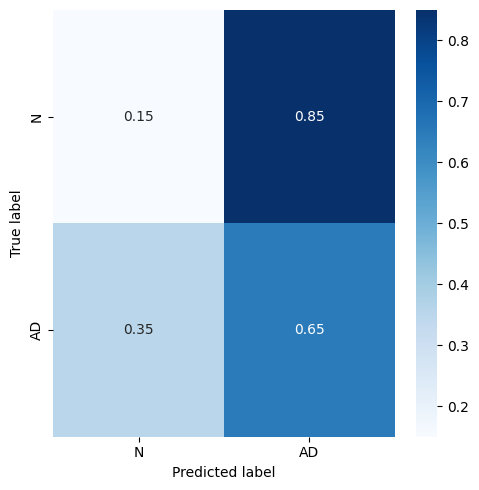

In [24]:
# # create confusion matrix
# if False and __name__ == '__main__':
import pandas as pd
import seaborn
y_pred = np.argmax(model.predict(x_data_test), axis=-1)
con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
classes = ['N', 'AD']
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize = (5, 5))
seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(working_dir + '/confusion_matrix_ICA.png', dpi = 600)
plt.show()